In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), incompatible header (14), mismatched flags (2))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal ~/.julia/packages/MLDataDevices/pxlxr/src/internal.jl:112


(::CPUDevice{Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

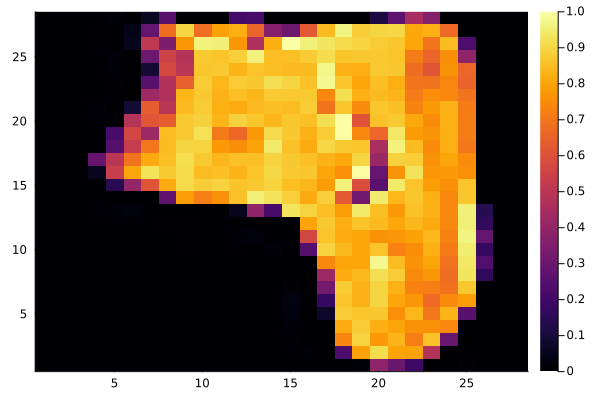

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [16]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [17]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),            # 100_480 parameters
    layer_4 = Dense(128 => 10),                   # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [18]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [19]:
yp, _ = model(x0, ps, st);

In [20]:
yp |> size

(10, 128)

In [21]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [22]:
loss_function(x0, y0, model, ps, st)

2.8641567f0

In [23]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CPU


(Any[2.8641567f0, 2.5659437f0, 2.387064f0, 2.1986299f0, 2.148335f0, 1.8518924f0, 1.7919455f0, 1.6326872f0, 1.6997683f0, 1.5456713f0  …  0.20519409f0, 0.18482399f0, 0.14162587f0, 0.23544107f0, 0.24074218f0, 0.16624248f0, 0.22450583f0, 0.22559026f0, 0.09765837f0, 0.15866928f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.038406536; 0.017918281; … ; 0.046671223; 0.019242242;;], scale = Float32[0.969162; 0.9840778; … ; 0.9716084; 0.98476076;;]), layer_3 = (weight = Float32[0.0062826984 0.11479646 … -0.08033957 0.10508532; -0.08677065 0.059964977 … 0.0745905 -0.092425995; … ; 0.073537506 -0.12590684 … -0.03909918 -0.11069321; 0.07812478 -0.0465651 … 0.033894457 0.032850184], bias = Float32[0.006977855, 0.0047661057, -0.0036222101, 0.012951335, -0.0019997153, -0.013606623, 0.023555515, 0.011161522, 0.044679105, 0.011207561  …  -0.005677891, -0.011133213, 0.0023209886, 0.019759463, 0.01545383, 0.04544099, 0.01437314, -0.0002253647, 0.03578561, -0.04288651]), layer_4 = (weight = Float

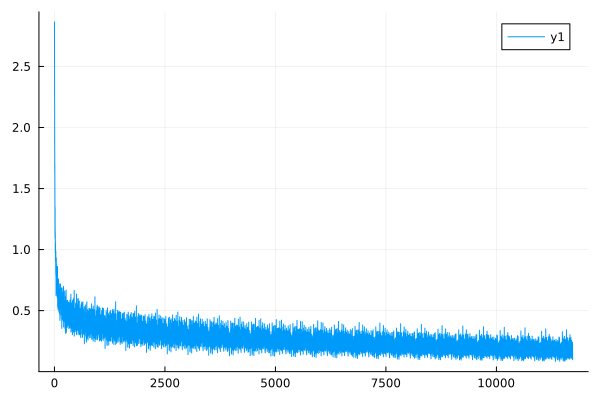

In [24]:
plot(losses)

In [25]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [26]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [27]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [28]:
test(model, test_loader, pst, stt)

0.8824

In [29]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [30]:
#automate_train(64, 5)

# Test Phasor network

In [31]:
import .PhasorNetworks: default_bias

In [32]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#33),
    layer_4 = WrappedFunction(#34),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),                 # 160 parameters
)         # Total: 104_416 parameters,
          #        plus 0 states.

In [33]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.053419817 -0.023526829 … 0.0057635712 0.031198414; -0.04953098 -0.012112024 … -0.05046695 -0.04445622; … ; -0.061836384 -0.011735573 … 0.038857743 -0.007830564; 0.03390087 0.03546983 … 0.024223208 -0.014435542],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.097034946 -0.08702092 … 0.0029376126 -0.14895976; 0.04700722 0.0051229917 … 0.09669124 0.041474987; … ; 0.08528399 -0.0691254 … -0.016995609 -0.024144253; -0.107117005 0.003897569 … -0.020065406 -0.1258004],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [34]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.015573662 0.25618333 … -0.17241937 0.13311985; 0.042849768 0.19231567 … 0.080118075 0.068582386; … ; 0.33967638 0.134624 … 0.2821272 0.08151369; 0.28529873 0.19141632 … 0.17220777 0.20563748], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple()))

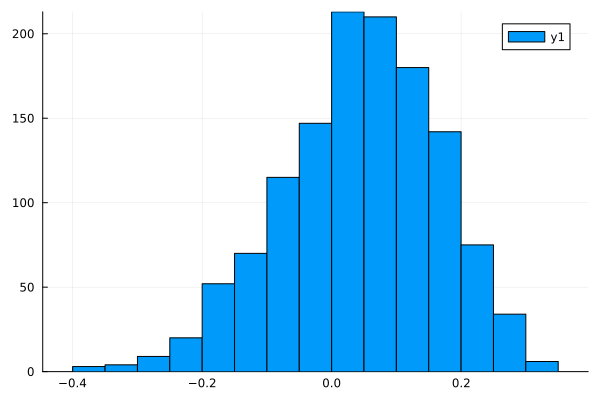

In [35]:
histogram(cdev(vec(yp0)))

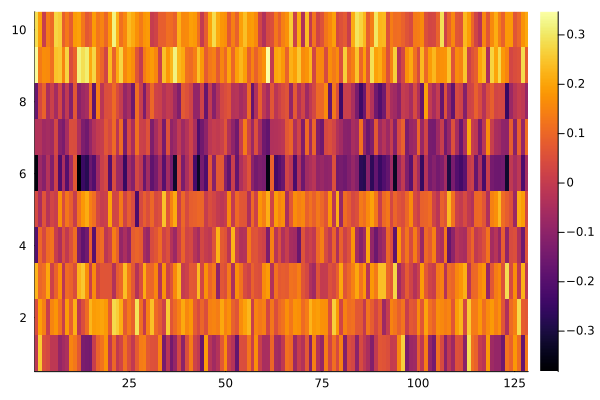

In [36]:
heatmap(cdev(yp0))

In [37]:
size(yp0)

(10, 128)

In [38]:
import .PhasorNetworks: codebook_loss

In [39]:
function codebook_loss(similarities::AbstractArray, truth::AbstractArray; dims=-1)
    if dims == -1
        dims = ndims(similarities)
    end

    prob = softmax(similarities, dims=dims)
    loss = CrossEntropyLoss(;logits=false, dims=dims)(prob, truth)
    
    return loss
end

codebook_loss (generic function with 1 method)

In [40]:
lbl = 1.0f0 .* onehotbatch(y0, 0:9);

In [41]:
yp0 |> size

(10, 128)

In [52]:
codebook_loss(yp0, lbl |> gdev, dims=1)

2.2989328f0

In [53]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = codebook_loss(y_pred, y_onehot, dims=1) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [54]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

2.2989328f0

In [55]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CPU


(Any[2.2989328f0, 2.2663825f0, 2.220908f0, 2.1859145f0, 2.1778576f0, 2.130112f0, 2.1087182f0, 2.1144958f0, 2.1140935f0, 2.103013f0  …  1.464513f0, 1.4699407f0, 1.4470205f0, 1.4881325f0, 1.4788677f0, 1.4756403f0, 1.4847459f0, 1.4918417f0, 1.4565393f0, 1.4768925f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.07668701; 0.1352783; … ; 0.03664011; 0.06832166;;], scale = Float32[0.913334; 0.8646261; … ; 0.93898165; 0.91932315;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.08177746 0.018472271 … 0.03444888 0.0654778; -0.041624337 0.004851158 … -0.06348015 -0.032788377; … ; -0.023856107 0.03969598 … 0.06998996 0.035208356; 0.004292169 0.021607125 … 0.014303734 -0.034884486],), bias = (bias_real = Float32[1.04009, 1.1169437, 1.1336062, 1.0854857, 1.0210009, 1.0114752, 1.2875437, 1.4199234, 1.050756, 1.1369188  …  1.0729759, 1.0533074, 0.98379433, 0.9261983, 1.0296625, 1.1923052, 1.2272228, 1.1871523, 1.2166553, 1.1433411], bias_imag = Float

In [ ]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.008484, 1.126583, 1.1514353, 1.1124102, 0.9943499, 0.961119, 1.3223808, 1.3706368, 1.067687, 1.1920971  …  1.0677178, 1.0366564, 0.9977855, 0.91471785, 1.0463414, 1.2069294, 1.3245113, 1.1942354, 1.2102966, 1.1718782], bias_imag = Float32[-0.14247209, -0.045340866, -0.027198672, -0.051720407, 0.029285988, 0.030268075, 0.005166746, -0.055860553, -0.053005476, -0.07098392  …  -0.065764256, -0.044367783, -0.0355847, 0.06285766, -0.010986761, -0.09141035, -0.019489326, -0.008909059, -0.041810915, -0.0052646673])

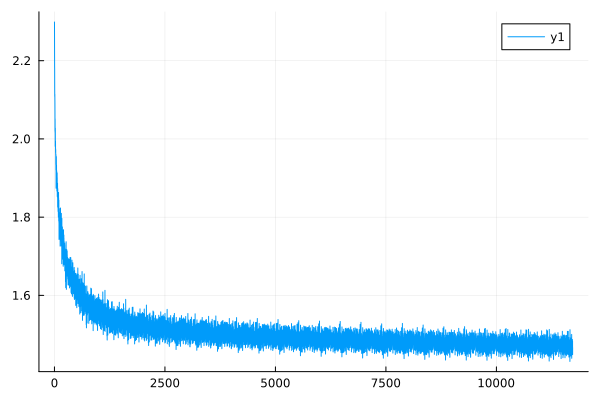

In [ ]:
plot(losses_f)

In [ ]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[-0.25596932 -0.07211587 … -0.031327806 0.9925819; 0.9780321 -0.07444584 … -0.015804458 -0.175566; … ; -0.20456474 -0.03713751 … -0.16730565 0.19534364; 0.8127341 -0.24454129 … -0.33471873 -0.27417785], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple()))

In [ ]:
size(yp1)

(128, 10)

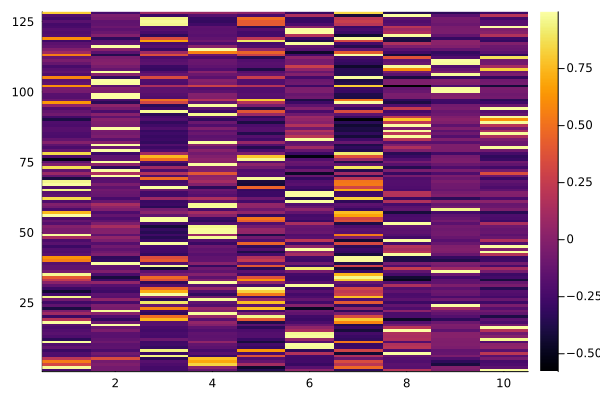

In [ ]:
heatmap(cdev(yp1))

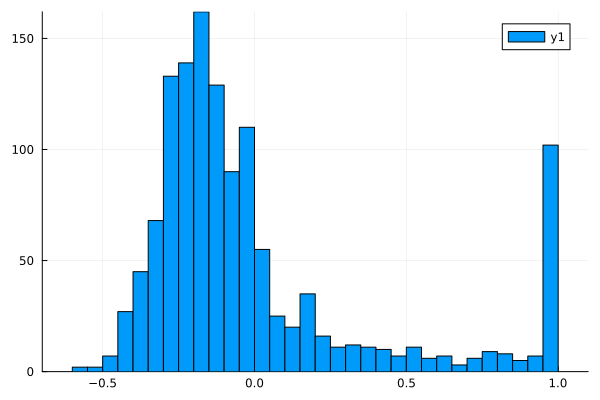

In [ ]:
histogram(vec(cdev(yp1)))

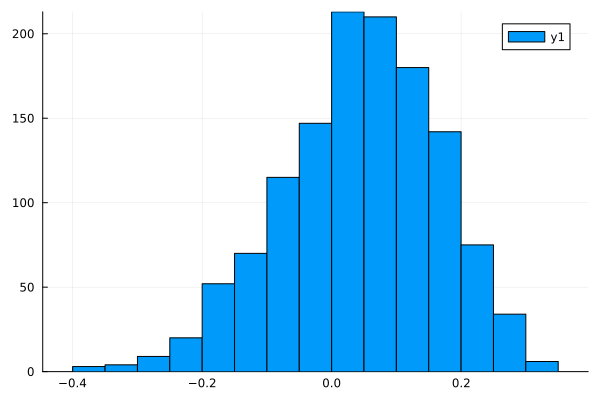

In [ ]:
histogram(cdev(vec(yp0)))

In [ ]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [ ]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8699

# Test spiking behavior

In [55]:
import .PhasorNetworks: Codebook, LuxParams

In [56]:
spk_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#38),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),                 # 160 parameters
)         # Total: 104_416 parameters,
          #        plus 0 states.

In [57]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0008010405 -0.0024223165 … -0.0026604207 -0.052246522; -0.05784539 0.038866077 … -0.014191841 0.054047313; … ; -0.047871105 -0.012310346 … -0.036755353 0.026587926; -0.055613305 -0.026476443 … 0.021711031 -0.0016106424],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.13288157 0.1230696 … 0.10437556 0.13046719; -0.10436164 -0.1396298 … 0.021995246 0.08833502; … ; -0.03142647 -0.026560916 … -0.13651504 0.12153221; 0.059181932 -0.07425366 … -0.05679883 0.03147752],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [58]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [59]:
ys0 |> size

(2001,)

In [60]:
ys0s = ys0 |> stack ;

In [61]:
size(ys0s)

(128, 10, 2001)

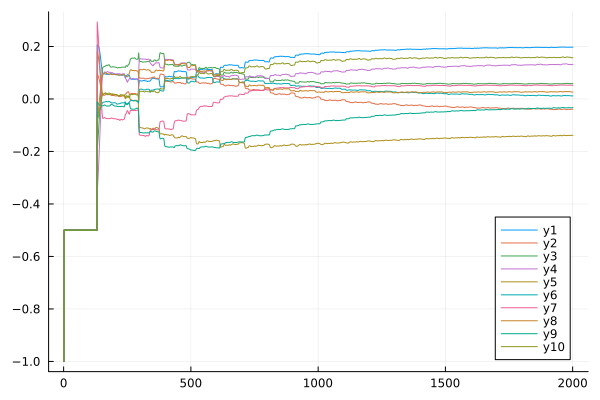

In [62]:
plot(ys0s[1,:,:]' |> cdev)

In [63]:
yp0 |> size

(128, 10)

In [64]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [65]:
y_spk_s = y_spk_f |> stack |> cdev;

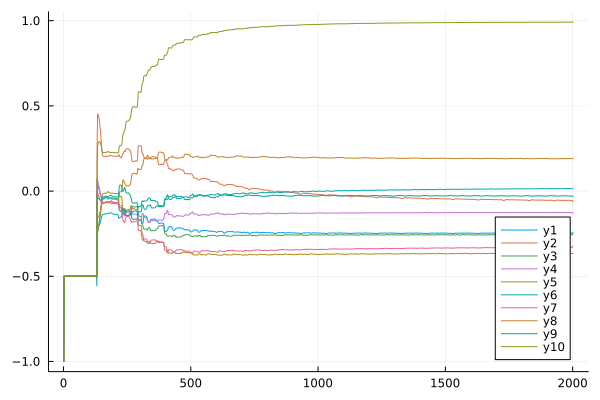

In [66]:
plot(y_spk_s[1,:,:]')

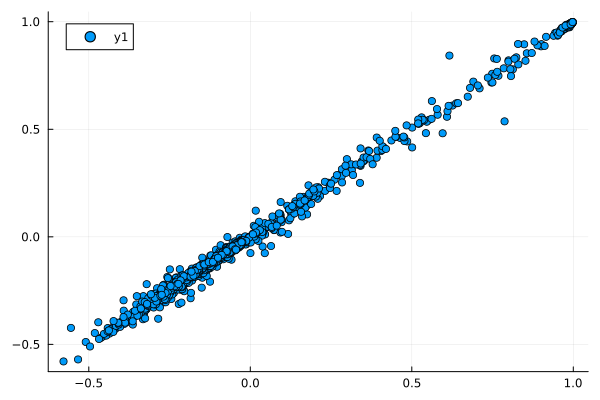

In [67]:
scatter(vec(cdev(yp1)), vec(y_spk_s[:,:,end]))

In [71]:
spk_inner = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            x -> x,
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#46),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = WrappedFunction(#47),
)         # Total: 104_256 parameters,
          #        plus 0 states.

In [72]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128), CartesianIndex(11, 128), CartesianIndex(12, 128), CartesianIndex(13, 128), CartesianIndex(14, 128), CartesianIndex(15, 128), CartesianIndex(16, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], Float32[1.9974959, 2.0026326, 2.0002859, 2.0057688, 1.9949005, 2.002131, 1.9986246, 2.0033247, 2.0073717, 1.9945838  …  21.002514, 21.016905, 21.489964, 20.995394, 20.997551, 20.501518, 21.005493, 20.997921, 20.501839, 20.503452], (16, 128), 2048, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTup

In [73]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (16, 128) with 10242 spikes.

In [74]:
st3_b1 = st3[:,1:5]

Spike Train: (16, 5) with 400 spikes.

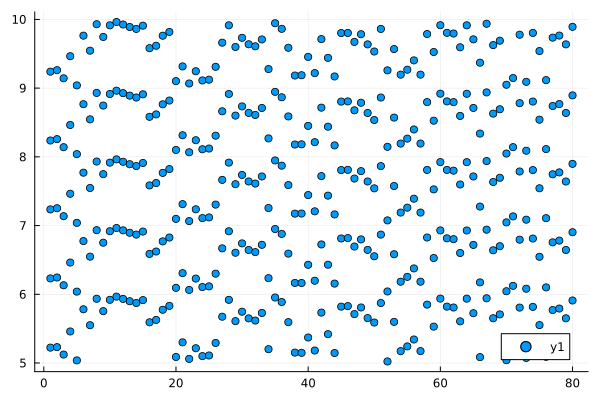

In [75]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [ ]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [77]:
ys0[end] |> size

(128, 10)

In [84]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    correct = 0
    num = 0
    
    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
        end
        
        sim_output, _ = model(x, ps, st)
        pred_labels = predict_codebook(cdev(sim_output[end]))

        correct += sum(pred_labels .== y .+ 1)
        num += length(y)
    end

    return correct/num
end

fmnist_spiking_accuracy (generic function with 1 method)

In [85]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

0.8695